In [1]:

import os
import gzip
import random
import shutil
import math
import json
import safe
import datetime
import pandas as pd
import numpy as np  
import datamol as dm
from multiprocessing import cpu_count, get_context, Pool
from datasets import Dataset, DatasetDict, load_dataset, load_from_disk
from transformers import (
    AutoConfig, 
    JambaForCausalLM,
    LlamaForCausalLM,
    GPT2LMHeadModel,
)
from safe.tokenizer import SAFETokenizer
from itertools import permutations
from functools import partial


/mnt/ps/home/CORP/yassir.elmesbahi/.conda_envs/smiles-rnn/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preparing datasets

In [2]:
def create_rnn_datasets(csv_file_path, output_dir, columns=[], compress=True):
    df = pd.read_csv(csv_file_path)
    if len(columns) == 0:
        columns = df.columns
    print(f"###### columns = {columns}")
    for col in list(columns):
        #if col == 'split':
        #    continue
        if col != 'safe-recap':
            continue
        print(f"###### Initial length = {len(df)} example(s)")
        
        print(f"###### Number of NaNs in column {col}: {df[col].isnull().sum()}")
        sub_df = df.dropna(subset=[col], how='all', inplace=False)
        splits = list(sub_df.split.unique())
        print(sub_df.columns)
        print(f"###### Processing '{col}' ({len(sub_df)} example(s))")
        print(f"###### Max length == '{max(list(map(len, sub_df[col].tolist())))}'")
        for split in splits:
            filepath = os.path.join(output_dir, f"{col}-{split}.smi")
            df_split = sub_df.loc[sub_df.split==split]
            l_fragments = df_split['smiles'].to_list()
            with open(filepath, 'w') as fp:
                fp.writelines("%s\n" % item for item in l_fragments)
            if compress == True:
                with open(f'{filepath}', 'rb') as f_in:
                    with gzip.open(f'{filepath}.gz', 'wb') as f_out:
                        shutil.copyfileobj(f_in, f_out)
                ## Removing '.smi' file
                os.remove(f'{filepath}')
            print(f">> {len(l_fragments)} example(s) in '{split}' split")


def parallel_compute(func, iterable, n_perms, cores = None, chunk=1000):
    if not cores:
        cores = cpu_count() - 1
    with get_context('fork').Pool(cores) as p:
        results =  p.map(partial(func, n_samples=n_perms), iterable, chunksize=chunk)
        p.close()
        p.join()
    return results

In [3]:
output_dir = "/mnt/ps/home/CORP/yassir.elmesbahi/ondemand/data/moses"
csv_file_path = f"{output_dir}/moses_safe.csv"

print(f"########## Creating rnn datasets ")
create_rnn_datasets(csv_file_path, output_dir, columns=[], compress=False)

########## Creating rnn datasets 


###### columns = Index(['smiles', 'split', 'safe-hr', 'safe-rotatable', 'safe-brics',
       'safe-recap', 'safe-mmpa'],
      dtype='object')
###### Initial length = 1936962 example(s)
###### Number of NaNs in column safe-recap: 31481
Index(['smiles', 'split', 'safe-hr', 'safe-rotatable', 'safe-brics',
       'safe-recap', 'safe-mmpa'],
      dtype='object')
###### Processing 'safe-recap' (1905481 example(s))
###### Max length == '99'
>> 1333669 example(s) in 'train' split
>> 190614 example(s) in 'valid' split
>> 381198 example(s) in 'test' split


In [3]:
def parallel_map(func, iterable, slicer, cores = None, chunk=None):
    if cores is None:
        cores = cpu_count() - 1
    if chunk is None:
        chunk = len(iterable) // cores
    with get_context('fork').Pool(cores) as p:
        results =  p.map(partial(func, slicer=slicer), iterable, chunksize=chunk)
        p.close()
        p.join()
    return results

def encode(string, slicer):
    encoded_string=None
    try:
        encoded_string = safe.encode(string, slicer=slicer)
    except Exception as err:
        print(f"Error at: {string}")
        return None
    return encoded_string
        
ROOT_DIR="/mnt/ps/home/CORP/yassir.elmesbahi/ondemand/data/moses"
#for slicer in ['hr', 'rotatable', 'brics', 'recap', 'mmpa']:
for slicer in ['recap']:
    print(f"###### Processing slicer '{slicer}'...")
    for split in ['train', 'valid', 'test']:
        print(f"#### Processing split '{split}'...")
        smiles, retain = [], []
        path = os.path.join(ROOT_DIR, f"safe-{slicer}-{split}.smi")
        print(f">> Opening file {path}...")
        
        with open(path, 'r') as fp:
            smiles = fp.read().splitlines() 
        
        print(f">> Processing {len(smiles)} lines...")
        retain = parallel_map(encode, smiles, slicer=slicer, cores = None, chunk=1)
        retain = list(filter(lambda x: x is not None, retain))

        if len(retain) and (len(retain) != len(smiles)):
            print(f">> Saving {len(retain)} lines...")
            path = os.path.join(ROOT_DIR, f"safe-{slicer}-{split}.smi")
            with open(path, 'w') as fp:
                fp.writelines(retain)
        else:
            print(f">> All smiles are valide, continuing...")
        print(f">> Done")



###### Processing slicer 'recap'...
#### Processing split 'train'...
>> Opening file /mnt/ps/home/CORP/yassir.elmesbahi/ondemand/data/moses/safe-recap-train.smi...
>> Processing 1333669 lines...


>> All smiles are valide, continuing...
>> Done
#### Processing split 'valid'...
>> Opening file /mnt/ps/home/CORP/yassir.elmesbahi/ondemand/data/moses/safe-recap-valid.smi...
>> Processing 190614 lines...
>> All smiles are valide, continuing...
>> Done
#### Processing split 'test'...
>> Opening file /mnt/ps/home/CORP/yassir.elmesbahi/ondemand/data/moses/safe-recap-test.smi...
>> Processing 381198 lines...
>> All smiles are valide, continuing...
>> Done


## Measuring models' fragmentation

In [ ]:

def parallel_map(func, iterable, cores = None, chunk=None):
    if cores is None:
        cores = cpu_count() - 1
    if chunk is None:
        chunk = len(iterable) // cores
    with get_context('fork').Pool(cores) as p:
        results =  p.map(func, iterable, chunksize=chunk)
        p.close()
        p.join()
    return results


def internal_diversity(safe_strings, is_smile=False, device='cpu', fp_type='morgan', p=1):
    """
    Computes internal diversity as:
    1/|A|^2 sum_{x, y in AxA} (1-tanimoto(x, y))
    """
    if is_smile == False:
        smiles_strings = parallel_map(_decode_fn, safe_strings)
    else:
        smiles_strings = safe_strings
    valid_smiles_strings = list(filter(lambda x: x is not None, smiles_strings))
    #gen_fps = list(map(encode_mol_smiles_to_fingerprint, valid_smiles_strings))
    gen_fps = fingerprints(valid_smiles_strings, fp_type=fp_type)
    return 1 - (average_agg_tanimoto(gen_fps, gen_fps,
                                     agg='mean', device=device, p=p)).mean()
    

def novelty(safe_strings, ref_smile_strings, is_smile=False):
    if is_smile == False:
        smiles_strings = parallel_map(_decode_fn, safe_strings)
    else:
        smiles_strings = safe_strings
    valid_smiles_strings = list(filter(lambda x: x is not None, smiles_strings))
    gen_smiles_set = set(valid_smiles_strings) - {None}
    ref_set = set(ref_smile_strings)
    return len(gen_smiles_set - ref_set) / len(gen_smiles_set) if len(gen_smiles_set) else 0.0

def validity(safe_strings, is_smile=False):
    if is_smile == False:
        smiles_strings = parallel_map(_decode_fn, safe_strings)
    else:
        smiles_strings = safe_strings
    smiles_strings = list(map(_decode_fn, safe_strings))
    valid_smiles_strings = list(filter(lambda x: x is not None, smiles_strings))
    return len(valid_smiles_strings) / len(safe_strings)

def uniqueness(safe_strings, only_valid=True, is_smile=False):
    if is_smile == False:
        smiles_strings = parallel_map(_decode_fn, safe_strings)
    else:
        smiles_strings = safe_strings
    valid_smiles_strings = list(filter(lambda x: x is not None, smiles_strings))
    if only_valid == False and len(smiles_strings) != len(valid_smiles_strings):
        return (len(np.unique(valid_smiles_strings)) + 1) / len(valid_smiles_strings) if len(valid_smiles_strings) else 0.0
    return len(np.unique(valid_smiles_strings)) / len(valid_smiles_strings) if len(valid_smiles_strings) else 0.0
    
    

def fragmentation(safe_strings):
    res = {}
    smiles_strings = parallel_map(_decode_fn, safe_strings)
    valid_safe_strings = [x for i,x in enumerate(safe_strings) if smiles_strings[i] is not None]
    all_fragmented = ["." in x for x in valid_safe_strings]
    ## Fragmented
    try:
        res['percentage'] = np.mean(all_fragmented) if len(all_fragmented) > 0 else 0.
    except:
        res['percentage'] = 0.
    
    ## Size
    res['size'] =np.round(np.array([np.mean([len(word) for word in str(sentence).split('.')]) for sentence in valid_safe_strings]).mean(),2)
    
    ## Number
    res['number'] = np.round(np.mean([1+sentence.count('.') for sentence in valid_safe_strings]), 2)
    return res

def get_datasets_metrics(datasets_dir, output_dir, n_samples=50000, seed=87):
    global_dic = {}
    for name in os.listdir(output_dir):
        data_path = os.path.join(datasets_dir, f"{name}")
        if not os.path.isdir(data_path):
            continue
        global_dic[name] = {
            "train_validity":0.0,
            "train_uniqueness":0.0,
            "train_internal_diversity":0.0,
            "train_fragmentation":{
                "percentage": 0.0,
                "number": 0.0,
                "size": 0.0,
            },
            "train_size":0,
            "valid_size":0,
            "test_size":0,
            }
        print(f"### Processing dataset {data_path}")
        print(f">> Loading dataset ...")
        ds = load_from_disk(data_path)
        global_dic[name]['train_size'] = len(ds['train'])
        global_dic[name]['valid_size'] = len(ds['valid'])
        global_dic[name]['test_size'] = len(ds['test'])
        ds = ds['train']
        if (n_samples is not None) and (n_samples < len(ds)):
            ds = ds.shuffle(seed=seed).select(range(n_samples))
        col = name.split('_')[0]
        train_data = ds[col]
        print(f">> Picking column '{col}', number of examples: {len(ds[ds.column_names[0]])}")
        print(f">> Calculating 'validity' ...")
        global_dic[name]['train_validity'] = validity(train_data, is_smile=("smiles" in name))
        print(f">> Calculating 'uniqueness' ...")
        global_dic[name]['train_uniqueness'] = uniqueness(train_data, is_smile=("smiles" in name))
        print(f">> Calculating 'internal_diversity' ...")
        global_dic[name]['train_internal_diversity'] = internal_diversity(train_data, is_smile=("smiles" in name))
        if not "smiles" in name:
            print(f">> Calculating 'fragmentation' ...")
            frag_dict = fragmentation(train_data)
            global_dic[name]['train_fragmentation']['percentage'] = frag_dict['percentage']
            global_dic[name]['train_fragmentation']['size'] = frag_dict['size']
            global_dic[name]['train_fragmentation']['number'] = frag_dict['number']
            print (f"Fragmentation is: {frag_dict}")
        print(f">> Done ...")
    with open(os.path.join(output_dir, "global_dic"), "w") as fp:
        json.dump(global_dic, fp, ensure_ascii=True, indent=4, sort_keys=True)
    return global_dic


In [ ]:
ds = load_from_disk("/mnt/ps/home/CORP/yassir.elmesbahi/ondemand/data/moses/safe-brics")
ds = ds['train']
ds = ds.shuffle(seed=99).select(range(1000))
fragmentation(ds['safe-brics'])

safe_strings == ['Cc1nc8c(C)s1.N15CCOC7C1.c19ccccc1.C45=O.C68.N46.C79', 'c15csc6n1.c16cc(Br)cs1.O=C3C5.C4CO.N34', 'Cc1ccc(C)c6c1.c15nnc7o1.c17ccsc1.C6C4=O.N45', 'Cc1ccc4cc1.n14nnc3c15.c15ccccc1F.C3O', 'Cc1nc(C#N)c6o1.N15CCOCC1(C)C.N16CCN4CC1.C4(=O)C5', 'c15cccc2cn[nH]c12.C16CN4CCO1.CCC6.C45=O', 'CCC(C)(C)C1=O.S4(C)(=O)=O.N12C.C2C3.N34', 'c15ccc2c(c1)ncn26.Cc1cccnc17.C47C.C35=O.C6CO.N34', 'c16cc(Cl)ccc15.c18ccc7nc1.C38=O.C47=O.CO3.N46.O5C', 'Cc1ccc7cc1.N15CCN4CC1.c16c(C)noc1C.C46=O.C57', 'Cc1onc7c15.c17ccccc1F.c16cccs1.C35=O.N34.C46', 'c17ccc(Cl)cc1.C2(=O)CC47.c15cc6c[nH]1.C35=O.C6(C)=O.CO2.N34', 'N3C1CCOc2ccccc21.N14CCCC15.c15cccs1.O=C34', 'N14CC2CCC1CN5C2.Cc1nc(C)c6o1.c15ncccn1.C46=O', 'c17cc2ccccc2[nH]c1=O.CC1CCCC6C1.C4(=O)C7.C56.N45', 'c14cccc6c1.N16CCNC1=O.c15ccccn1.O=C35.N34', 'c17ccc2c(c1)OCO2.Cn1nnn8c1=O.c18ccc6cc1.C57=O.N56', 'c17ccc2[nH]ccc2c1.c18[nH]c(C)c9c1C.C48=O.C59=O.CC6.O46.N57', 'Nc1cc5ccc13.n14cncn1.C5(F)(F)F.C2(=O)C4.N23', 'S5(=O)(=O)c1ccc2c(c1)CNCC2.C3CC4.CO3.N45', '

smiles_strings == ['Cc1nc(CNC(=O)N2CCOC(Cc3ccccc3)C2)c(C)s1', 'O=C(Cc1csc(-c2cc(Br)cs2)n1)NCCO', 'Cc1ccc(C)c(CC(=O)Nc2nnc(-c3ccsc3)o2)c1', 'Cc1ccc(-n2nnc(CO)c2-c2ccccc2F)cc1', 'Cc1nc(C#N)c(N2CCN(C(=O)CN3CCOCC3(C)C)CC2)o1', 'CCCC1CN(C(=O)c2cccc3cn[nH]c23)CCO1', 'CCC(C)(C)C(=O)N(C)CCNS(C)(=O)=O', 'Cc1cccnc1C(C)NC(=O)c1ccc2c(c1)ncn2CCO', 'COC(=O)c1ccc(C(=O)Nc2cc(Cl)ccc2OC)nc1', 'Cc1ccc(CN2CCN(C(=O)c3c(C)noc3C)CC2)cc1', 'Cc1onc(-c2ccccc2F)c1C(=O)NCc1cccs1', 'COC(=O)CC(NC(=O)c1cc(C(C)=O)c[nH]1)c1ccc(Cl)cc1', 'O=C(NC1CCOc2ccccc21)N1CCCC1c1cccs1', 'Cc1nc(C)c(C(=O)N2CC3CCC2CN(c2ncccn2)C3)o1', 'CC1CCCC(CNC(=O)Cc2cc3ccccc3[nH]c2=O)C1', 'O=C(Nc1cccc(N2CCNC2=O)c1)c1ccccn1', 'Cn1nnn(-c2ccc(NC(=O)c3ccc4c(c3)OCO4)cc2)c1=O', 'CCOC(=O)c1[nH]c(C)c(C(=O)Nc2ccc3[nH]ccc3c2)c1C', 'Nc1cc(C(F)(F)F)ccc1NC(=O)Cn1cncn1', 'COCCCNS(=O)(=O)c1ccc2c(c1)CNCC2', 'COC(=O)C1=C(C)C(C(=O)COC(=O)c2ccncc2)=NC1C', 'CC1CN(C(=O)COc2ccc(S(C)(=O)=O)cc2)CCO1', 'COC1=CC(=O)C(=C2NNC=C2c2ccc3c(c2)OCCO3)C=C1', 'Cc1cc(NC(=O)NCCCSc2nnc(

{'percentage': 1.0, 'size': 8.07, 'number': 5.42}

In [ ]:
output_dir = "/mnt/ps/home/CORP/yassir.elmesbahi/ondemand/data/moses"
dic = get_datasets_metrics(output_dir, output_dir)
dic

### Processing dataset /mnt/ps/home/CORP/yassir.elmesbahi/ondemand/data/moses/safe-brics
>> Loading dataset ...


>> Picking column 'safe-brics', number of examples: 50000
>> Calculating 'validity' ...
>> Calculating 'uniqueness' ...
>> Calculating 'internal_diversity' ...
>> Calculating 'fragmentation' ...
Fragmentation is: {'percentage': 1.0, 'size': 8.04, 'number': 5.41}
>> Done ...
### Processing dataset /mnt/ps/home/CORP/yassir.elmesbahi/ondemand/data/moses/safe-brics_10000
>> Loading dataset ...
>> Picking column 'safe-brics', number of examples: 10000
>> Calculating 'validity' ...
>> Calculating 'uniqueness' ...
>> Calculating 'internal_diversity' ...
>> Calculating 'fragmentation' ...
Fragmentation is: {'percentage': 1.0, 'size': 8.09, 'number': 5.4}
>> Done ...
### Processing dataset /mnt/ps/home/CORP/yassir.elmesbahi/ondemand/data/moses/safe-mmpa_100000
>> Loading dataset ...
>> Picking column 'safe-mmpa', number of examples: 50000
>> Calculating 'validity' ...
>> Calculating 'uniqueness' ...
>> Calculating 'internal_diversity' ...
>> Calculating 'fragmentation' ...
Fragmentation is: {'p

{'safe-brics': {'train_validity': 1.0,
  'train_uniqueness': 1.0,
  'train_internal_diversity': 0.855829393082843,
  'train_fragmentation': {'percentage': 1.0, 'number': 5.41, 'size': 8.04},
  'train_size': 1346886,
  'valid_size': 192439,
  'test_size': 384926},
 'safe-brics_10000': {'train_validity': 1.0,
  'train_uniqueness': 1.0,
  'train_internal_diversity': 0.8557593558432006,
  'train_fragmentation': {'percentage': 1.0, 'number': 5.4, 'size': 8.09},
  'train_size': 10000,
  'valid_size': 192439,
  'test_size': 384926},
 'safe-mmpa_100000': {'train_validity': 1.0,
  'train_uniqueness': 1.0,
  'train_internal_diversity': 0.8560745335584473,
  'train_fragmentation': {'percentage': 1.0, 'number': 7.55, 'size': 6.42},
  'train_size': 100000,
  'valid_size': 193662,
  'test_size': 387308},
 'safe-rotatable': {'train_validity': 1.0,
  'train_uniqueness': 1.0,
  'train_internal_diversity': 0.8562777923173461,
  'train_fragmentation': {'percentage': 1.0, 'number': 6.35, 'size': 7.09},
  

In [ ]:
dic

{'safe-brics': {'validity': 1.0,
  'uniqueness': 1.0,
  'internal_diversity': 0.855829393082843,
  'fragmentation': {'percentage': 0.0, 'number': 0.0, 'size': 0.0},
  'percentage': 0.0,
  'size': 35.92,
  'number': 1.0},
 'safe-brics_10000': {'validity': 1.0,
  'uniqueness': 1.0,
  'internal_diversity': 0.8557593558432006,
  'fragmentation': {'percentage': 0.0, 'number': 0.0, 'size': 0.0},
  'percentage': 0.0,
  'size': 36.01,
  'number': 1.0},
 'safe-mmpa_100000': {'validity': 1.0,
  'uniqueness': 1.0,
  'internal_diversity': 0.8560745335584473,
  'fragmentation': {'percentage': 0.0, 'number': 0.0, 'size': 0.0},
  'percentage': 0.0,
  'size': 35.91,
  'number': 1.0},
 'safe-rotatable': {'validity': 1.0,
  'uniqueness': 1.0,
  'internal_diversity': 0.8562777923173461,
  'fragmentation': {'percentage': 0.0, 'number': 0.0, 'size': 0.0},
  'percentage': 0.0,
  'size': 35.89,
  'number': 1.0},
 'safe-rotatable_augmented': {'validity': 1.0,
  'uniqueness': 0.81378,
  'internal_diversity': 0

In [ ]:
'smiles_1000'.split('_')[0]

'smiles'

In [ ]:
for item in os.listdir(output_dir):
    if os.path.isdir(os.path.join(output_dir,item)):
        print(f"{item} is a directory")
    else:
        print(f"{item} is NOT a directory")

In [ ]:
ds['train'].column_names

## Measuring models' sizes

In [ ]:
def get_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    return trainable_params, all_param

def get_num_trainable_parameters(model):
    """
    Get the number of trainable parameters.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def get_model_size(tokenizer_path, cfg_path, model_cls):
    tokenizer = SAFETokenizer.load(tokenizer_path)
    config = AutoConfig.from_pretrained(cfg_path)
    config.vocab_size = len(tokenizer)
    #model = GPT2LMHeadModel(config)
    model = model_cls(config)
    embedding_size = model.get_input_embeddings().weight.shape[0]
    if len(tokenizer) > embedding_size:
        model.resize_token_embeddings(len(tokenizer))
        model.config.vocab_size = len(tokenizer)
    return get_trainable_parameters(model)

In [ ]:
PROJ_DIR="/mnt/ps/home/CORP/yassir.elmesbahi/project/safe-setup-models"
tokenizer_path=f"{PROJ_DIR}/src/configs/tokenizer/tokenizer-wordlevel-smiles.json"

models_names=["gpt2", "llama", "jamba"]
cfgs_paths=[
    f"{PROJ_DIR}/src/configs/model_cfg/gpt2-small.json",
    f"{PROJ_DIR}/src/configs/model_cfg/llama-small.json",
    f"{PROJ_DIR}/src/configs/model_cfg/jamba-small.json",
]
cls_names=[GPT2LMHeadModel, LlamaForCausalLM, JambaForCausalLM]

for name, path, cls_name in zip(models_names, cfgs_paths, cls_names):
    print(f"model {name} has {get_model_size(tokenizer_path, path, cls_name)} parameters")

model gpt2 has (9538560, 9538560) parameters
model llama has (8293888, 8293888) parameters
model jamba has (8680862, 8680862) parameters


N46.c19ccccc1.C45=O.N15CCOC7C1.C68.Cc1nc8c(C)s1.C79
C45=O.Cc1nc8c(C)s1.N15CCOC7C1.C68.N46.c19ccccc1.C79
c19ccccc1.N15CCOC7C1.Cc1nc8c(C)s1.N46.C45=O.C79.C68
N15CCOC7C1.C68.C79.C45=O.c19ccccc1.Cc1nc8c(C)s1.N46
C45=O.N46.C68.c19ccccc1.C79.Cc1nc8c(C)s1.N15CCOC7C1
N15CCOC7C1.C79.Cc1nc8c(C)s1.c19ccccc1.C68.C45=O.N46
N46.c19ccccc1.Cc1nc8c(C)s1.C79.C68.N15CCOC7C1.C45=O
C79.Cc1nc8c(C)s1.C45=O.N15CCOC7C1.N46.C68.c19ccccc1
C45=O.Cc1nc8c(C)s1.C79.C68.N46.N15CCOC7C1.c19ccccc1
C45=O.N46.N15CCOC7C1.C79.C68.c19ccccc1.Cc1nc8c(C)s1


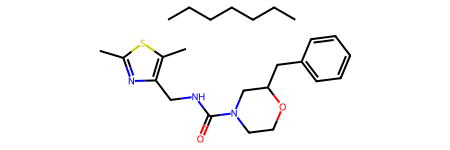

In [ ]:
import numpy as np
import datamol as dm

def randomize_fragments( samples):
    randomized = np.random.permutation(samples.split("."))
    return ".".join(randomized)

samples = 'Cc1nc8c(C)s1.N15CCOC7C1.c19ccccc1.C45=O.C68.N46.C79'
for batch in range(10):
    cur_sample = randomize_fragments(samples)
    print(cur_sample)
dm.to_mol(samples+".CCCCCCC")
